### Pytorch Built-in Transformer on IC

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import torch.optim as optim

from torch.utils.data import DataLoader
import sys
import os

#Custom
import utilities
torch.max_split_size_mb = 6000

#### Import Dataset, Calculate Means and Covariances of Bonds and Angles

In [2]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'decaalanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

whole_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)

In [5]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

In [6]:
for batch_idx, (data, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
    data = utilities.flatten_data(data) #for deccalanine
    #tr_cov, tr_means, bonds_angles_dist = utilities.return_ba_mean_covar(data, dec=False)

#del tr_cov, tr_means, whole_loader

#### Binning Code

In [7]:
def create_boundaries(num_bins, lower_bound, upper_bound):
    data_range = upper_bound - lower_bound
    delta = data_range/num_bins
    result = []
    current = lower_bound
    for iter in range(0, num_bins, 1):
        result.append(current)
        current = current + delta
    return result

def custom_bucketize(input_, num_bins, lower_bound = -torch.pi, upper_bound = torch.pi):
    bounds = torch.tensor( create_boundaries(num_bins, lower_bound, upper_bound) )
    return torch.bucketize(input_, bounds)

def un_bucketize_dict(num_bins, lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = dict()
    data_range = upper_bound - lower_bound
    delta = data_range/num_bins
    lower_value = lower_bound + delta/2
    for iter in range(0, num_bins+1, 1):
        unbucket_dict[iter] = lower_value
        lower_value = lower_value + delta
    return unbucket_dict

def un_bucketize(input_, num_bins, device=torch.device('cuda'), 
                lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = un_bucketize_dict(num_bins, lower_bound=-torch.pi, upper_bound=torch.pi)
    np_input = input_.cpu().numpy()
    return np.vectorize(unbucket_dict.get)(np_input)

p_x = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole])

In [8]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

dataloader_test = DataLoader(dataset_test,
                              num_workers = 8,
                              batch_size = 1280,
                              shuffle = False)

### Calculate Energies

In [9]:
def rebuild(flat, data_length = 99):
    #data_length = 19 #this is particular to dialene
    result = {}
    result['reference_particle_1_xyz'] = torch.zeros((flat.shape[0], 3))
    result['reference_particle_2_bond'] = flat[:, 0]
    result['reference_particle_3_bond'] = flat[:, 1]
    result['reference_particle_3_angle'] = flat[:, 2]

    start = 3
    end = start + data_length
    result['bond'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['angle'] = flat[:, start:end]

    start = end
    end = start + data_length
    result['dihedral'] = flat[:, start:end]

    return result

/home/gridsan/jzheng/.conda/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/BucketizationUtils.h:28.)
  del sys.path[0]
/home/gridsan/jzheng/.conda/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


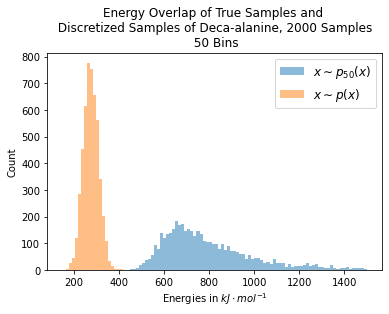

In [10]:
data_small = data[0:5000, :]
ba = data_small[:, :-99]
dihedrals = data_small[:, 201:]
bucketized_dihedrals = custom_bucketize(dihedrals, 50)
unbucketized_dihedrals = un_bucketize(bucketized_dihedrals, 50)
approx = torch.cat([ba, torch.tensor(unbucketized_dihedrals)], dim=1)
approx = rebuild(torch.tensor(approx), data_length=99)
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(approx)
plt.hist(potential_energy_q_theta, range =(150, 1500), bins = 100, alpha = 0.5, label = "$x \sim p_{50}(x)$")
plt.hist(p_x[0:5000], range =(150, 1500), bins = 100, alpha = 0.5, label = "$x \sim p(x)$")
plt.title("Energy Overlap of True Samples and \n Discretized Samples of Deca-alanine, 2000 Samples \n 50 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

/home/gridsan/jzheng/.conda/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


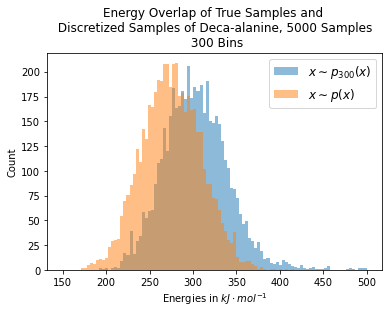

In [11]:
data_small = data[0:5000, :]
ba = data_small[:, :-99]
dihedrals = data_small[:, 201:]
bucketized_dihedrals = custom_bucketize(dihedrals, 300)
unbucketized_dihedrals = un_bucketize(bucketized_dihedrals, 300)
approx = torch.cat([ba, torch.tensor(unbucketized_dihedrals)], dim=1)
approx = rebuild(torch.tensor(approx), data_length=99)
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(approx)

plt.hist(potential_energy_q_theta, range =(150, 500), bins = 100, alpha = 0.5, label = "$x \sim p_{300}(x)$")
plt.hist(p_x[0:5000], range =(150, 500), bins = 100, alpha = 0.5, label = "$x \sim p(x)$")
plt.title("Energy Overlap of True Samples and \n Discretized Samples of Deca-alanine, 5000 Samples \n 300 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

/home/gridsan/jzheng/.conda/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


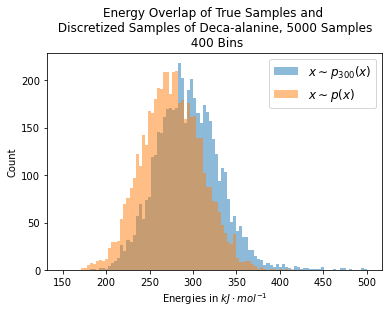

In [12]:
data_small = data[0:5000, :]
ba = data_small[:, :-99]
dihedrals = data_small[:, 201:]
bucketized_dihedrals = custom_bucketize(dihedrals, 400)
unbucketized_dihedrals = un_bucketize(bucketized_dihedrals, 400)
approx = torch.cat([ba, torch.tensor(unbucketized_dihedrals)], dim=1)
approx = rebuild(torch.tensor(approx), data_length=99)
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(approx)

plt.hist(potential_energy_q_theta, range =(150, 500), bins = 100, alpha = 0.5, label = "$x \sim p_{300}(x)$")
plt.hist(p_x[0:5000], range =(150, 500), bins = 100, alpha = 0.5, label = "$x \sim p(x)$")
plt.title("Energy Overlap of True Samples and \n Discretized Samples of Deca-alanine, 5000 Samples \n 400 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

#### 629 Bins

/home/gridsan/jzheng/.conda/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


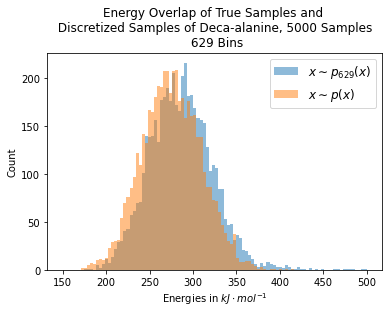

In [13]:
data_small = data[0:5000, :]
ba = data_small[:, :-99]
dihedrals = data_small[:, 201:]
bucketized_dihedrals = custom_bucketize(dihedrals, 629)
unbucketized_dihedrals = un_bucketize(bucketized_dihedrals, 629)
approx = torch.cat([ba, torch.tensor(unbucketized_dihedrals)], dim=1)
approx = rebuild(torch.tensor(approx), data_length=99)
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(approx)

plt.hist(potential_energy_q_theta, range =(150, 500), bins = 100, alpha = 0.5, label = "$x \sim p_{629}(x)$")
plt.hist(p_x[0:5000], range =(150, 500), bins = 100, alpha = 0.5, label = "$x \sim p(x)$")
plt.title("Energy Overlap of True Samples and \n Discretized Samples of Deca-alanine, 5000 Samples \n 629 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

#### 200 Bins

/home/gridsan/jzheng/.conda/envs/UROP/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


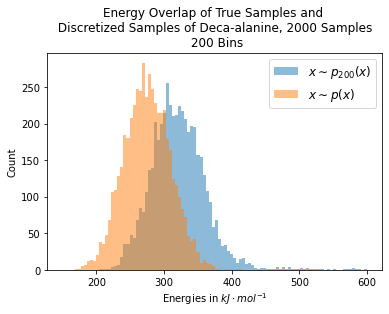

In [16]:
data_small = data[0:5000, :]
ba = data_small[:, :-99]
dihedrals = data_small[:, 201:]
bucketized_dihedrals = custom_bucketize(dihedrals, 200)
unbucketized_dihedrals = un_bucketize(bucketized_dihedrals, 200)
approx = torch.cat([ba, torch.tensor(unbucketized_dihedrals)], dim=1)
approx = rebuild(torch.tensor(approx), data_length=99)
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(approx)
plt.hist(potential_energy_q_theta, range =(150, 600), bins = 100, alpha = 0.5, label = "$x \sim p_{200}(x)$")
plt.hist(p_x[0:5000], range =(150, 600), bins = 100, alpha = 0.5, label = "$x \sim p(x)$")
plt.title("Energy Overlap of True Samples and \n Discretized Samples of Deca-alanine, 2000 Samples \n 200 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

$$p_{629}(x)$$
$$p(x)$$